In [1]:
import basedosdados as bd

In [2]:
tb = bd.Table('quantidade_municipio_nome_2010','br_ibge_nomes_brasil')

In [3]:
tb.create(
    if_storage_data_exists='pass',
    if_table_config_exists='pass',
    if_table_exists='replace'
)

In [4]:
tb.publish('replace')

In [1]:
## caged_brach
%reload_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

import basedosdados as bd
from geobr import read_municipality, read_state

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.ticker as mtick
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import  OffsetImage
from matplotlib import colors, cm

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Divisões economicas

In [8]:
query = """
WITH caged as (
  SELECT
    ano,
    CONCAT(ano,"-",id_municipio) as id_municipio,
    sigla_uf,
    admitidos_desligados,
    SUBSTR(cnae_2, 1, 2) as divisao_economica,
  FROM `basedosdados.br_me_caged.microdados_antigos`
),

caged2 as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    SAFE_CAST(divisao_economica as INT64) as divisao_economica,
    COUNTIF(admitidos_desligados = 1) as admitidos_total,
    COUNTIF(admitidos_desligados = 2) as desligados_total,
  FROM caged
  GROUP BY 1,2,3,4
  ORDER BY id_municipio, admitidos_total DESC
),

caged3 as (
  SELECT 
      ano,
      id_municipio,
      sigla_uf,
      divisao_economica as id_divisao_economica,
      CASE
            WHEN (divisao_economica>=1  AND divisao_economica<=3)  THEN "AGROPECUÁRIA"
            WHEN (divisao_economica>=5  AND divisao_economica<=9)  THEN "OUTROS"
            WHEN (divisao_economica>=10 AND divisao_economica<=33) THEN "INDÚSTRIAS"
            WHEN (divisao_economica>=35 AND divisao_economica<=35) THEN "OUTROS"
            WHEN (divisao_economica>=36 AND divisao_economica<=39) THEN "OUTROS"
            WHEN (divisao_economica>=41 AND divisao_economica<=43) THEN "CONSTRUÇÃO"
            WHEN (divisao_economica>=45 AND divisao_economica<=47) THEN "COMÉRCIO"
            WHEN (divisao_economica>=49 AND divisao_economica<=53) THEN "TRANSPORTE"
            WHEN (divisao_economica>=55 AND divisao_economica<=56) THEN "OUTROS"
            WHEN (divisao_economica>=58 AND divisao_economica<=63) THEN "OUTROS"
            WHEN (divisao_economica>=64 AND divisao_economica<=66) THEN "OUTROS"
            WHEN (divisao_economica>=68 AND divisao_economica<=68) THEN "OUTROS"
            WHEN (divisao_economica>=69 AND divisao_economica<=75) THEN "OUTROS"
            WHEN (divisao_economica>=77 AND divisao_economica<=82) THEN "OUTROS"
            WHEN (divisao_economica>=84 AND divisao_economica<=84) THEN "OUTROS"
            WHEN (divisao_economica>=85 AND divisao_economica<=85) THEN "OUTROS"
            WHEN (divisao_economica>=86 AND divisao_economica<=88) THEN "OUTROS"
            WHEN (divisao_economica>=90 AND divisao_economica<=93) THEN "OUTROS"
            WHEN (divisao_economica>=94 AND divisao_economica<=96) THEN "OUTROS"
            WHEN (divisao_economica>=97 AND divisao_economica<=97) THEN "OUTROS"
            WHEN (divisao_economica>=99 AND divisao_economica<=99) THEN "OUTROS"
      END AS divisao_economica,
      admitidos_total,
      desligados_total
  FROM caged2
),

caged4 as (
  SELECT event.* FROM (
    SELECT ARRAY_AGG(
      caged3 ORDER BY caged3.admitidos_total DESC LIMIT 1
    )[OFFSET(0)]  event
    FROM caged3 
    # GROUP BY the id you are de-duplicating by
    GROUP BY caged3.id_municipio 
  )
)


SELECT
  ano,
  SAFE_CAST(SUBSTR(id_municipio,6,11) AS INT64) as id_municipio,
  sigla_uf,
  divisao_economica,
  admitidos_total,
  desligados_total
FROM caged4
"""

caged = bd.read_sql(query, billing_project_id='basedosdados-dev')
caged_2019 = caged[caged['ano']==2019]

Downloading: 100%|██████████| 71733/71733 [00:04<00:00, 16274.92rows/s]


In [9]:
# Read all municipalities in the country at a given year
mun = read_municipality(code_muni="all", year=2019)
states = read_state(code_state="all", year=2019)
df = pd.merge(caged_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
df = gpd.GeoDataFrame(df)

df_count = caged_2019[['divisao_economica']].copy()
df_count['count'] = 1
df_count = df_count.groupby(by='divisao_economica', as_index=False).sum().sort_values(by='count')


caged_graph=caged[['ano','divisao_economica']]
caged_graph['count']=1
caged_graph = caged_graph.groupby(['ano','divisao_economica'], as_index=False).sum()
caged_graph = caged_graph.sort_values(by=['count'],ascending=False)
caged_graph = caged_graph.pivot_table(columns='divisao_economica',index=['ano'], values='count')
caged_graph = caged_graph.div(caged_graph.sum(axis=1), axis=0)*100
caged_graph = caged_graph.reset_index()

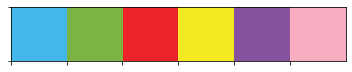

In [8]:
#2605459 Fernando de Noronha
#3205309 Vitoria

# import seaborn as sns
# sns.palplot(px_bar_colors)

### Divisoes Economicas MAPA

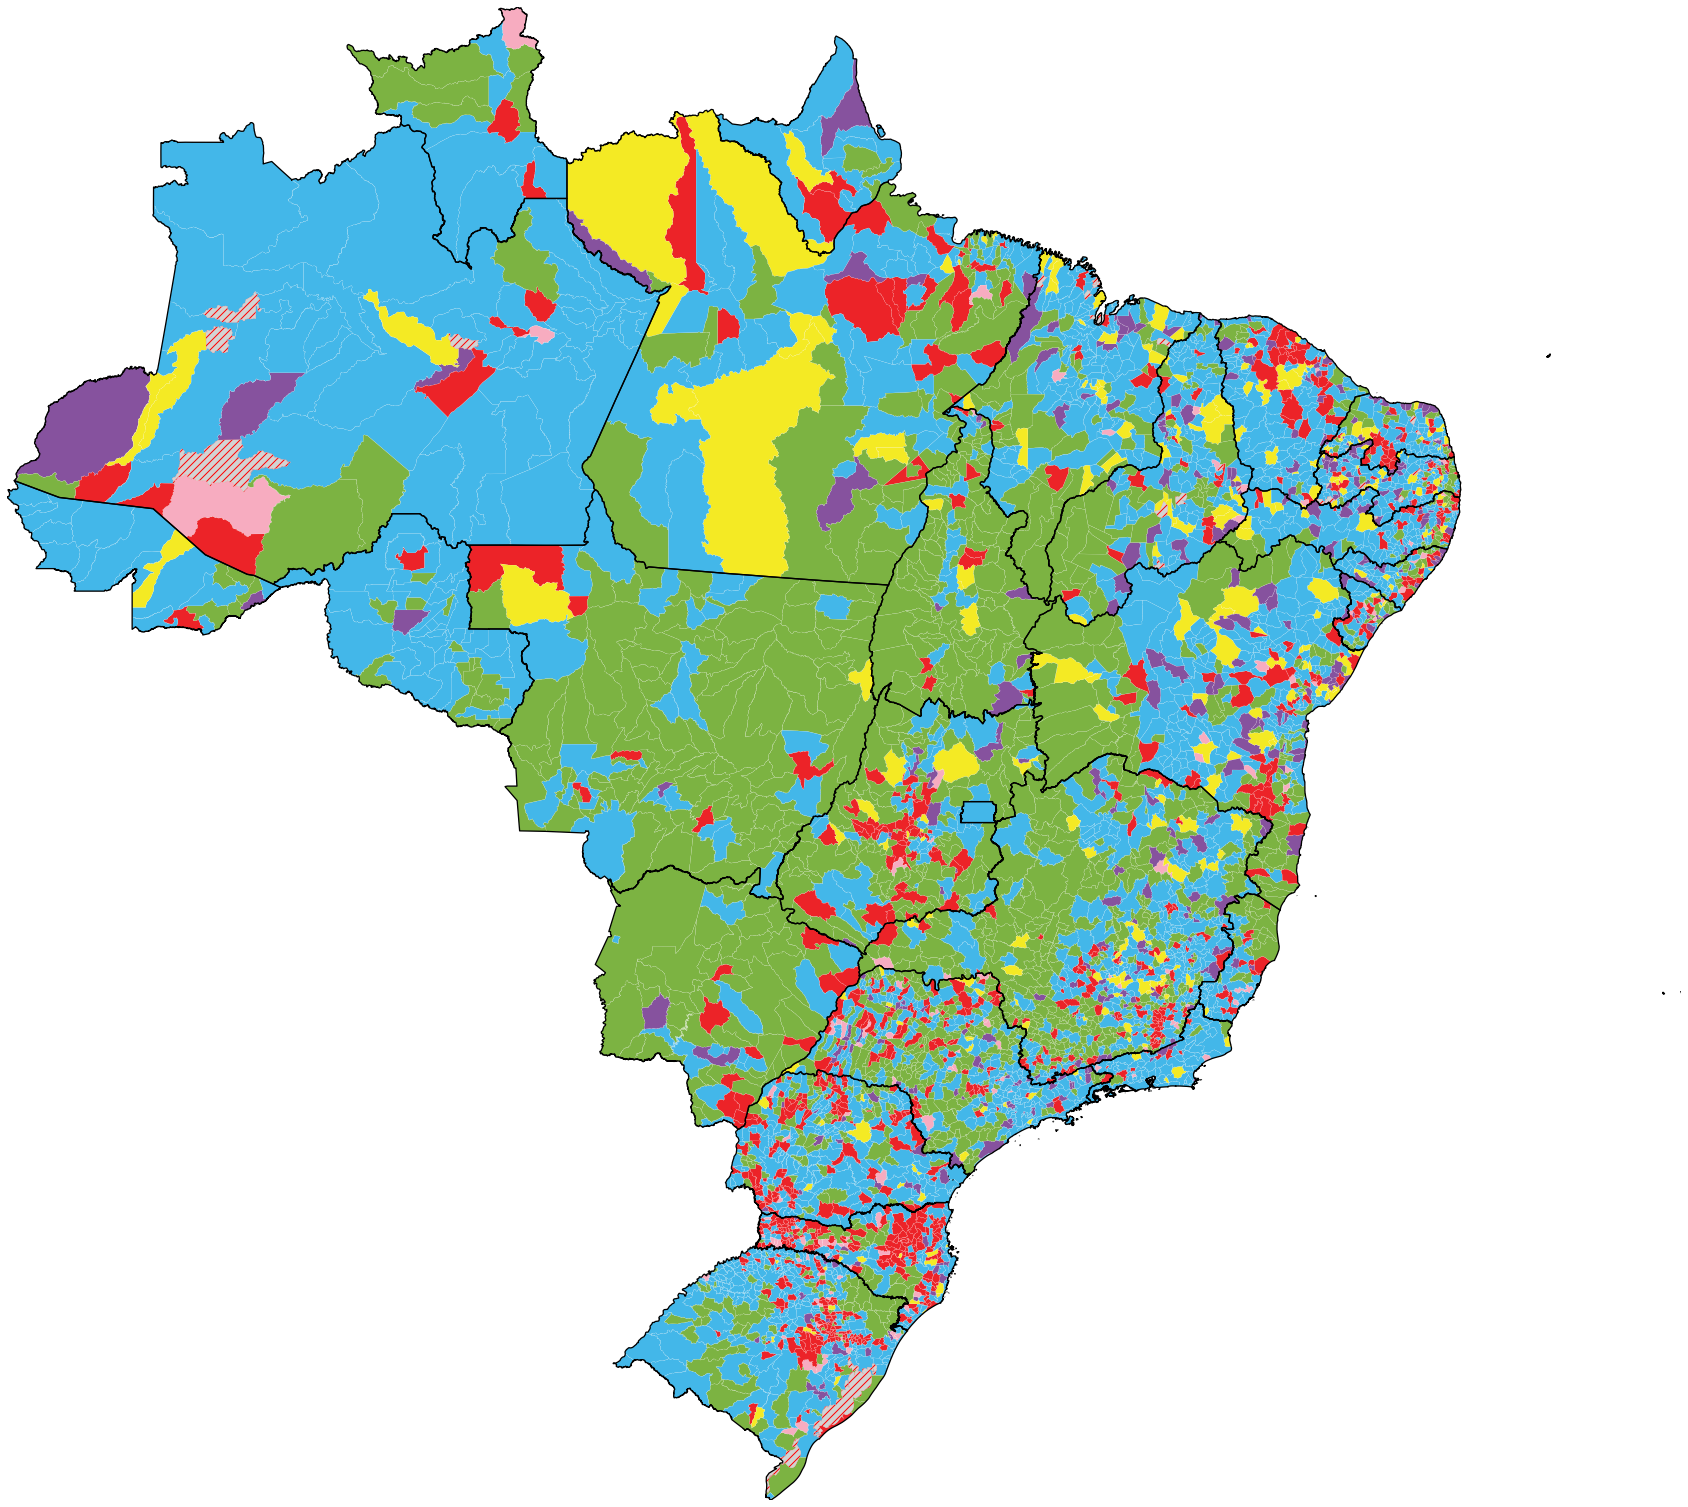

In [12]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot()

colors = [
    "#7cb342",
    "#43B7E9",
    "#F4EA24",
    "#EC2328",
    "#86529E",
    "#F7ACC0",
    
]

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

df.plot(column='divisao_economica',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
        missing_kwds=missing_kwds,
        edgecolor='#FFFFFF',
        linewidth = 0.1
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax1)

ax1.axis('off')
ax1.margins(x=0, y=0)

# plt.savefig('../images/tipos_contratacoes_mapa.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Quantidade de divisoes economicas por municipio em 2019

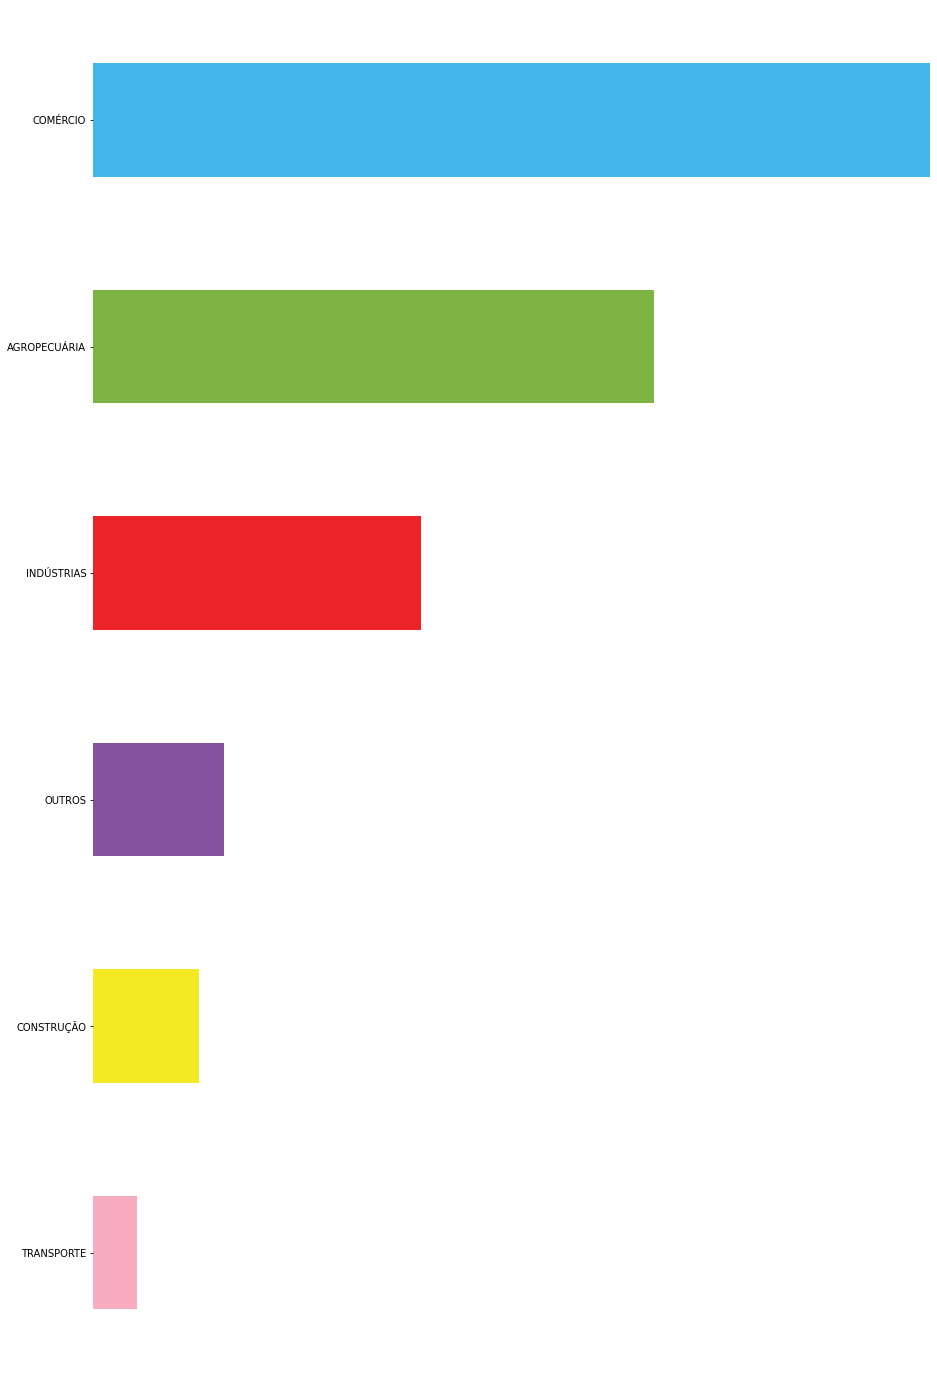

In [13]:
fig = plt.figure(figsize=(15,25))
ax2 = plt.subplot()

px_bar_colors = [
    "#43B7E9",
    "#7cb342",
    "#EC2328",
    "#86529E",
    "#F4EA24",
    "#F7ACC0",
    
]

df_count.plot.barh(
    x='divisao_economica',
    y='count',
    ax=ax2,
    color=px_bar_colors[::-1],
    legend=False
)



ax2.set_ylabel('', fontsize=20)
ax2.axes.get_xaxis().set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.margins(x=0, y=0)

# ax2.set_yticklabels([])
# ax2.set_xticklabels([])

# plt.savefig('../images/tipos_contratacoes_bar.pdf', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Serie temporal divisoes economicas

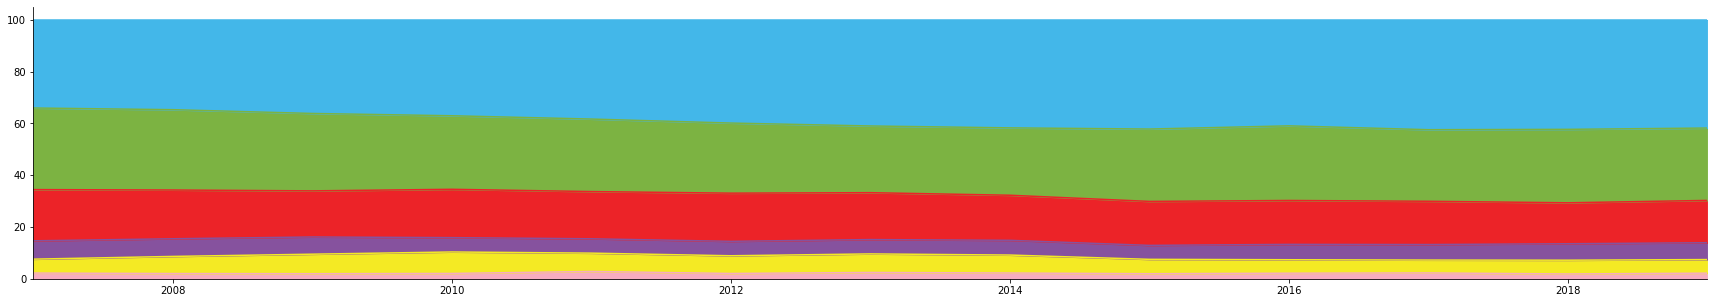

In [14]:

fig = plt.figure(figsize=(30,5))
ax3 = plt.subplot()
px_area_colors = [
    "#F7ACC0",
    "#F4EA24",
    "#86529E",
    "#EC2328",
    "#7cb342",
    "#43B7E9",
]
cols = ['ano', 'TRANSPORTE', 'CONSTRUÇÃO','OUTROS', 'INDÚSTRIAS', 'AGROPECUÁRIA', 'COMÉRCIO']

caged_graph[cols].plot.area(
    x='ano',
    color=px_area_colors,
    ax=ax3,
    legend=False

)
# ax3.set_title('Evolução dos tipos de contratações mais comuns no Brasil', fontsize=32,pad=0,fontweight='bold')

ax3.set_xlabel('', fontsize=22)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.margins(x=0, y=0)
# ax3.set_yticklabels([])
# ax3.set_xticklabels([])


# plt.savefig('../images/tipos_contratacoes_evolucao.pdf', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

### Divisoes economicas infographic

<Figure size 2160x2160 with 0 Axes>

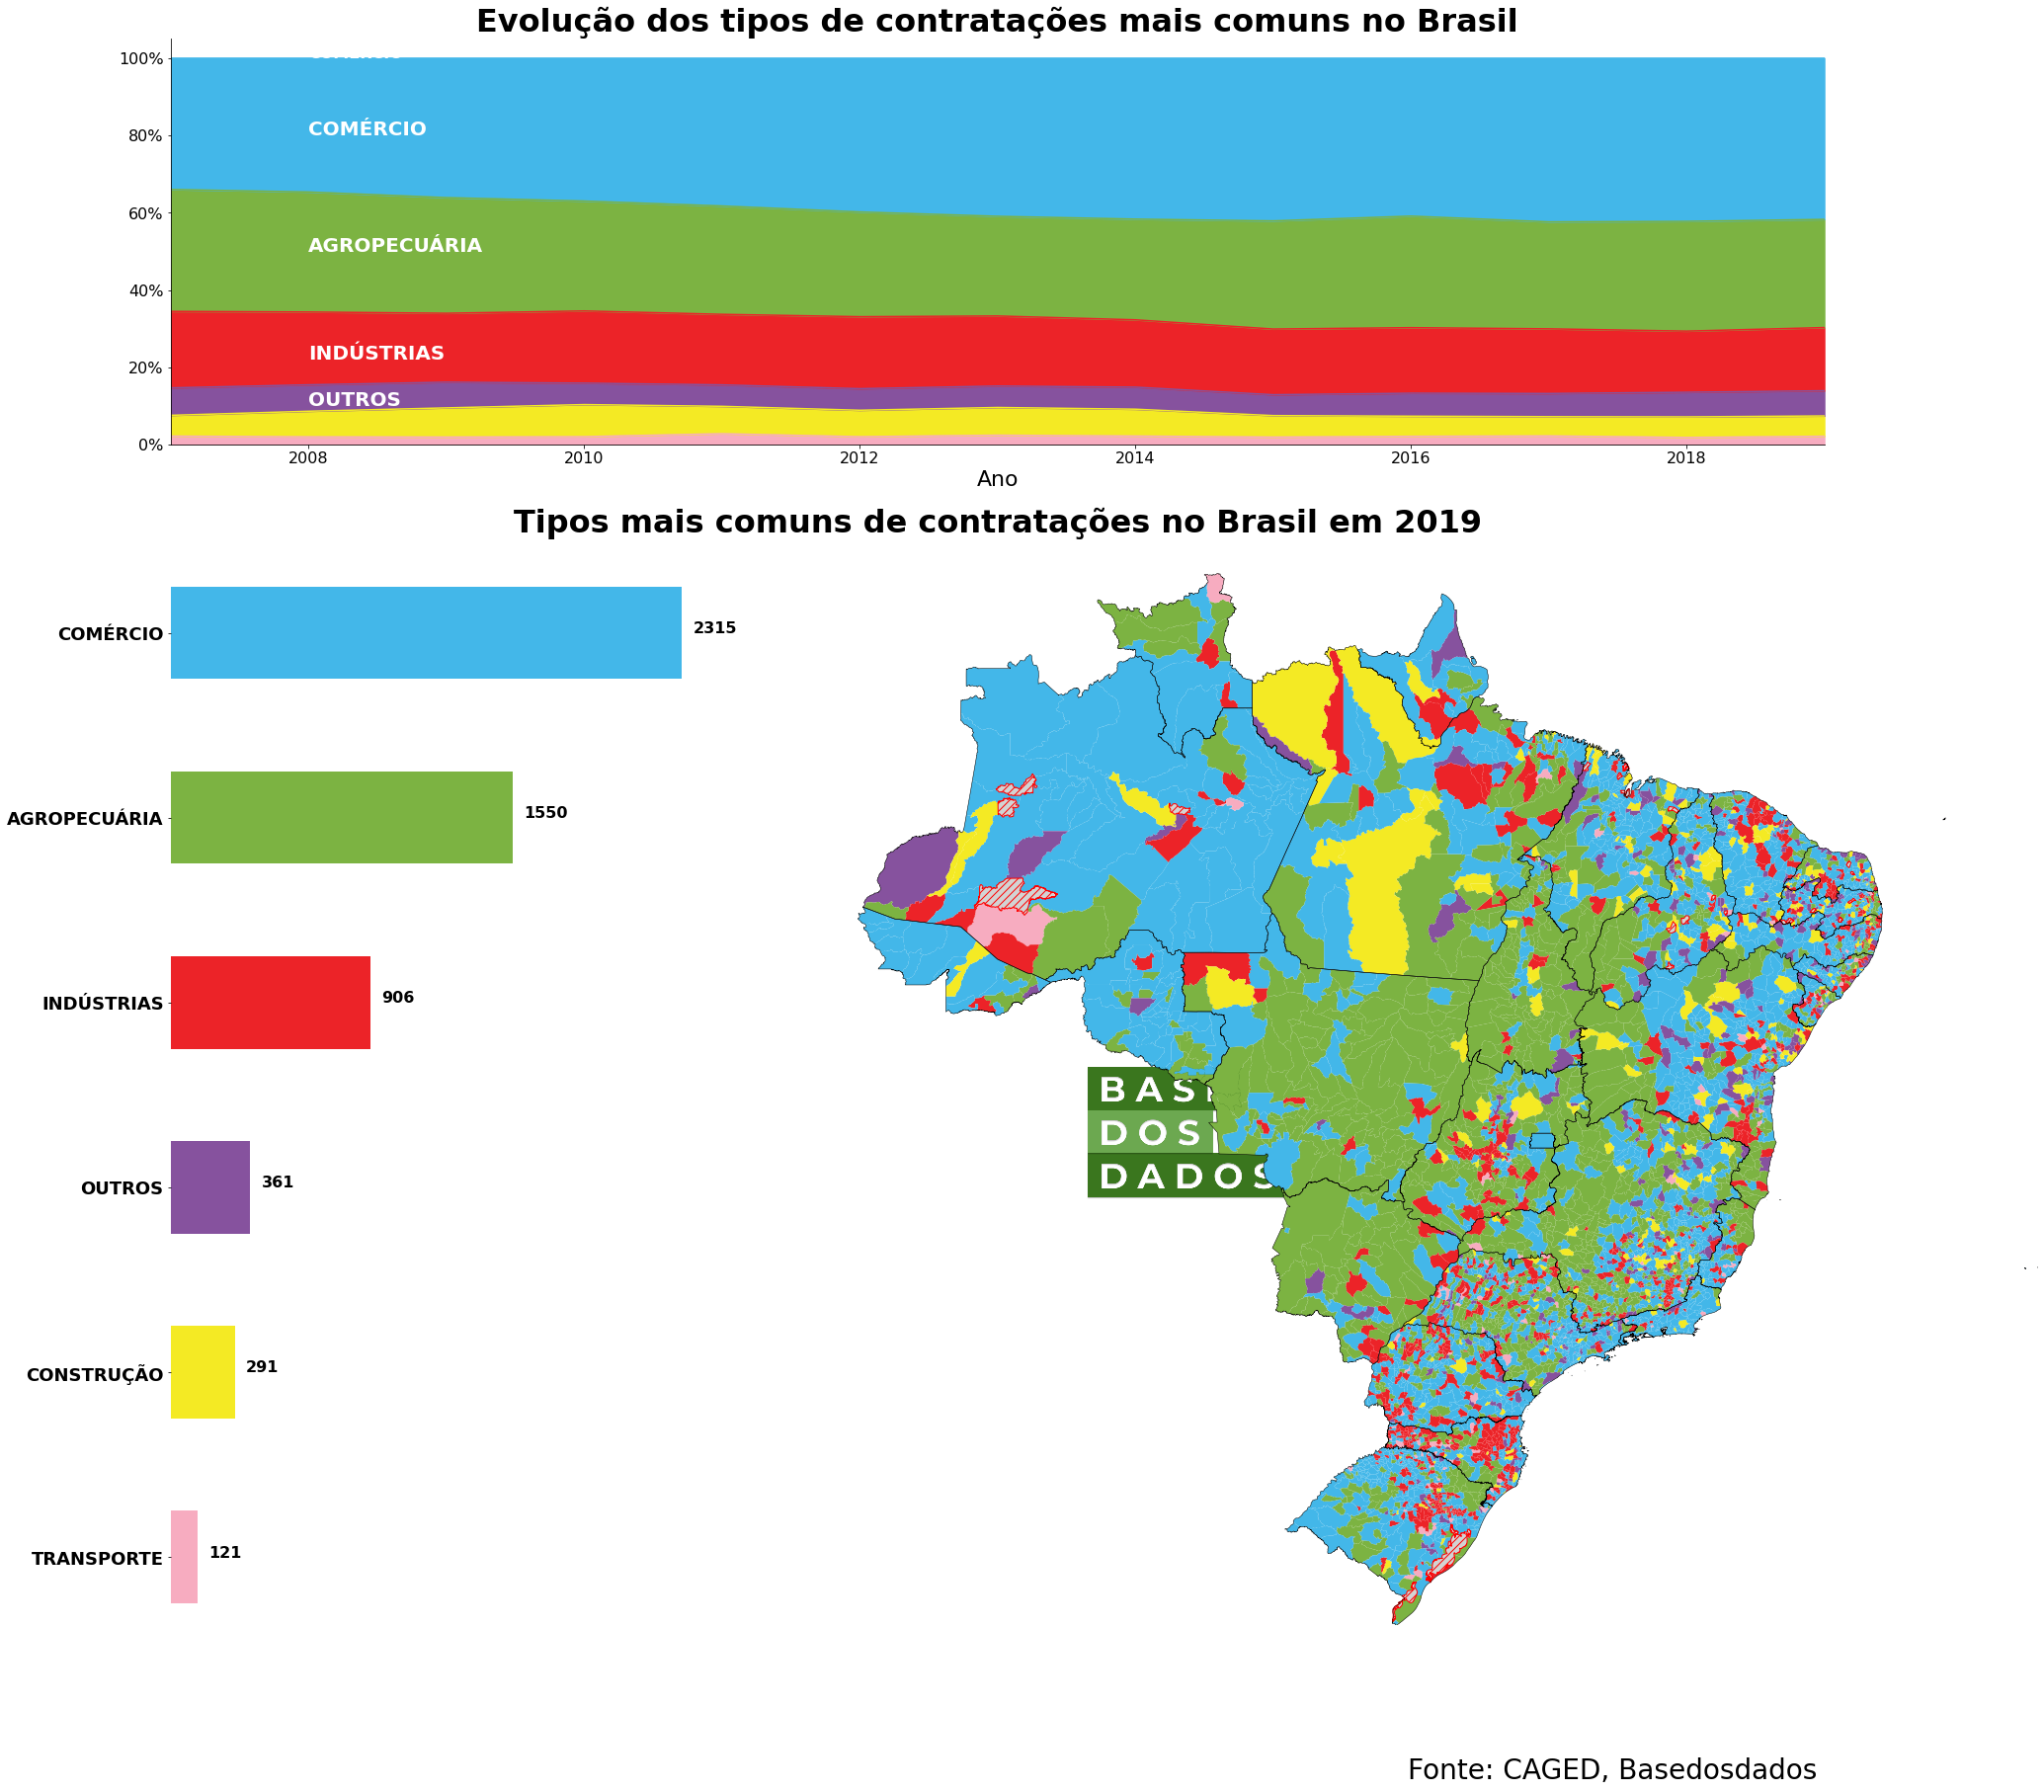

In [15]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(30,30))
grid = plt.GridSpec(3,2, width_ratios=[1,1.8] ,height_ratios=[1,0.000001,2.5])

fig = plt.figure(figsize=(30,30))
ax3  = plt.subplot(grid[0,:2])
axtitle  = plt.subplot(grid[1,:2])
ax2  = plt.subplot(grid[2,:1])
ax1 = plt.subplot(grid[2, 1:])

pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0, pos.width, pos.height+0.044])

pos = ax1.get_position()
ax1.set_position([pos.x0, pos.y0, pos.width+0.1, pos.height+0.04])

axtitle.set_title('Tipos mais comuns de contratações no Brasil em 2019', fontsize=32,fontweight='bold')
axtitle.axis('off')
# divider = make_axes_locatable(ax)

# ax1.set_title('Tipos mais comuns de contratações no Brasil em 2019', fontsize=22,fontweight='bold')

colors = [
    "#7cb342",
    "#43B7E9",
    "#F4EA24",
    "#EC2328",
    "#86529E",
    "#F7ACC0",
    
]

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

# Create a colormap using only the colours in this group
cmap = ListedColormap(colors)

legend_kwds = {
    'loc': 'best',
    'fontsize':18

}

remove_ilhas = (df['id_municipio']!=3205309) |(df['id_municipio']!=2605459)
mask = (df['name_region']=='Centro Oeste')
df.plot(column='divisao_economica',
        categorical=True,
        cmap=cmap,
        ax=ax1, 
#         legend=True,
        legend_kwds=legend_kwds,
        missing_kwds=missing_kwds
       )
states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 0.5, ax=ax1)

ax1.axis('off')

##############################===========================================================##############################

# for idx, row in mun_votos.iterrows():
#     plt.annotate(s=str(row['votos']), xy=row['coords'],fontsize=15,
#                  horizontalalignment='center', color='#ffffff')

px_bar_colors = [
    "#43B7E9",
    "#7cb342",
    "#EC2328",
        "#86529E",
    "#F4EA24",
    "#F7ACC0",
    
]

df_count.plot.barh(
    x='divisao_economica',
    y='count',
    ax=ax2,
    color=px_bar_colors[::-1],
    legend=False
)

# ax2.set_title('Tipos mais comuns de contratações no Brasil em 2019', fontsize=20,fontweight='bold')


ax2.xaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_tick_params(labelsize=18)
for tick in ax2.get_yticklabels():
    tick.set_weight("bold")
    
    
ax2.set_xlabel('Quantidade de municípios', fontsize=20)
ax2.set_ylabel('', fontsize=20)

ax2.axes.get_xaxis().set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)




for y, x  in enumerate(df_count['count']):
    ax2.text(x+50 , y, str(x), color='black', fontweight='bold', fontsize=16)

    
##############################===========================================================##############################

px_area_colors = [
    "#F7ACC0",
    "#F4EA24",
    "#86529E",
    "#EC2328",
    "#7cb342",
    "#43B7E9",
]
cols = ['ano', 'TRANSPORTE', 'CONSTRUÇÃO','OUTROS', 'INDÚSTRIAS', 'AGROPECUÁRIA', 'COMÉRCIO']

caged_graph[cols].plot.area(
    x='ano',
    color=px_area_colors,
    ax=ax3,
    legend=False

)
ax3.set_title('Evolução dos tipos de contratações mais comuns no Brasil', fontsize=32,pad=0,fontweight='bold')

ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
ax3.set_xlabel('Ano', fontsize=22)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.text(2008 ,100, 'COMÉRCIO' ,color='white', fontweight='bold', fontsize=16)
ax3.annotate('COMÉRCIO', (2008, 80),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.annotate('AGROPECUÁRIA', (2008, 50),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.annotate('INDÚSTRIAS', (2008, 22),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.annotate('OUTROS', (2008, 10),
            fontsize=20,
            fontweight='bold',
             color='white'
            )
ax3.yaxis.set_major_formatter(mtick.PercentFormatter())
ax3.margins(x=0, y=0)


ax2.text(5600,-1.20,'Fonte: CAGED, Basedosdados',fontsize=28)


logo=image.imread("../images/bd_logo.png")
# You have to add your own logo, this is in my own folder
addLogo = OffsetImage(logo, zoom=0.25)
#addLogo.set_zorder(100)
addLogo.set_offset((1100,600))
ax2.add_artist(addLogo)

ax1.margins(x=0, y=0)
plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig('../images/tipos_contratacoes.pdf', transparent=True)

# SALARIO

In [52]:
query = """
SELECT
ano,
id_municipio,
sigla_uf,
admitidos_desligados,
salario_mensal
FROM `basedosdados.br_me_caged.microdados_antigos`
WHERE ano=2019 and sigla_uf='AM' and id_municipio=1303502
"""

bug = bd.read_sql(query, billing_project_id='basedosdados-dev')


Downloading: 100%|██████████| 4/4 [00:00<00:00,  7.81rows/s]


In [53]:
bug

ano  id_municipio sigla_uf  admitidos_desligados  salario_mensal
0  2019       1303502       AM                     1          2302.0
1  2019       1303502       AM                     2          1984.0
2  2019       1303502       AM                     1          3120.0
3  2019       1303502       AM                     2          2000.0

In [42]:
query = """
WITH caged as (
  SELECT
    ano,
    id_municipio,
    sigla_uf,
    admitidos_desligados,
    salario_mensal
  FROM `basedosdados.br_me_caged.microdados_antigos`
) 

SELECT 
  ano,
  id_municipio,
  sigla_uf,
  AVG(salario_mensal) as media_salario,
  APPROX_QUANTILES(salario_mensal,1000)[OFFSET(500)] as mediana_salario
FROM caged
WHERE admitidos_desligados=1
GROUP BY 1,2,3
"""
caged_salario = bd.read_sql(query, billing_project_id='basedosdados-dev')
caged_salario_2019 = caged_salario[caged_salario['ano']==2019]

Downloading: 100%|██████████| 71321/71321 [00:04<00:00, 17625.11rows/s]


In [45]:
caged_salario_2019 = caged_salario[caged_salario['ano']==2018]

In [46]:
caged_salario_2019
dd = pd.merge(caged_salario_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
dd = gpd.GeoDataFrame(dd).sort_values(by='media_salario', ascending=False)

In [50]:
mask = (dd['mediana_salario']>1800) & (np.logical_not(dd['sigla_uf'].isin(['PR','RS','SC','SP','MT'])))
dd[mask].sort_values(by='mediana_salario', ascending=False)[['id_municipio','name_muni','name_state','mediana_salario']].reset_index(drop=True)

id_municipio                     name_muni           name_state  \
0      2309904.0                        Pacujá                Ceará   
1      1303502.0                        Pauini             Amazônas   
2      1300201.0              Atalaia Do Norte             Amazônas   
3      3171501.0                Mathias Lobato         Minas Gerais   
4      2513943.0        São Domingos Do Cariri              Paraíba   
5      2110302.0       Santo Antônio Dos Lopes             Maranhão   
6      2504504.0                       Condado              Paraíba   
7      2513000.0                    Salgadinho              Paraíba   
8      3171204.0                    Vespasiano         Minas Gerais   
9      2400703.0             Alto Do Rodrigues  Rio Grande do Norte   
10     1301506.0                        Envira             Amazônas   
11     1508357.0              Vitória Do Xingu                 Pará   
12     1503002.0                          Faro                 Pará   
13     1300631.0                        Beruri             Amazônas   
14     1504901.0                         Muaná                 Pará   
15     2414456.0              Triunfo Potiguar  Rio Grande do Norte   
16     2310605.0                     Penaforte                Ceará   
17     2929206.0        São Francisco Do Conde                Bahia   
18     1505205.0                Oeiras Do Pará                 Pará   
19     2105658.0             Junco Do Maranhão             Maranhão   
20     3154507.0           Riacho Dos Machados         Minas Gerais   
21     2409605.0                   Pedra Preta  Rio Grande do Norte   
22     1718006.0     Porto Alegre Do Tocantins            Tocantins   
23     2106102.0                        Loreto             Maranhão   
24     2111631.0  São Raimundo Do Doca Bezerra             Maranhão   
25     3121407.0        Desterro De Entre Rios         Minas Gerais   

    mediana_salario  
0            3800.0  
1            3500.0  
2            3000.0  
3            2900.0  
4            2739.0  
5            2535.0  
6            2490.0  
7            2490.0  
8            2344.0  
9            2331.0  
10           2302.0  
11           2235.0  
12           2192.0  
13           2192.0  
14           2192.0  
15           2099.0  
16           2093.0  
17           2048.0  
18           1997.0  
19           1991.0  
20           1909.0  
21           1908.0  
22           1908.0  
23           1903.0  
24           1896.0  
25           1832.0

(-76.24758052684999, -26.59070825414999, -35.70232894755, 7.222992030549998)

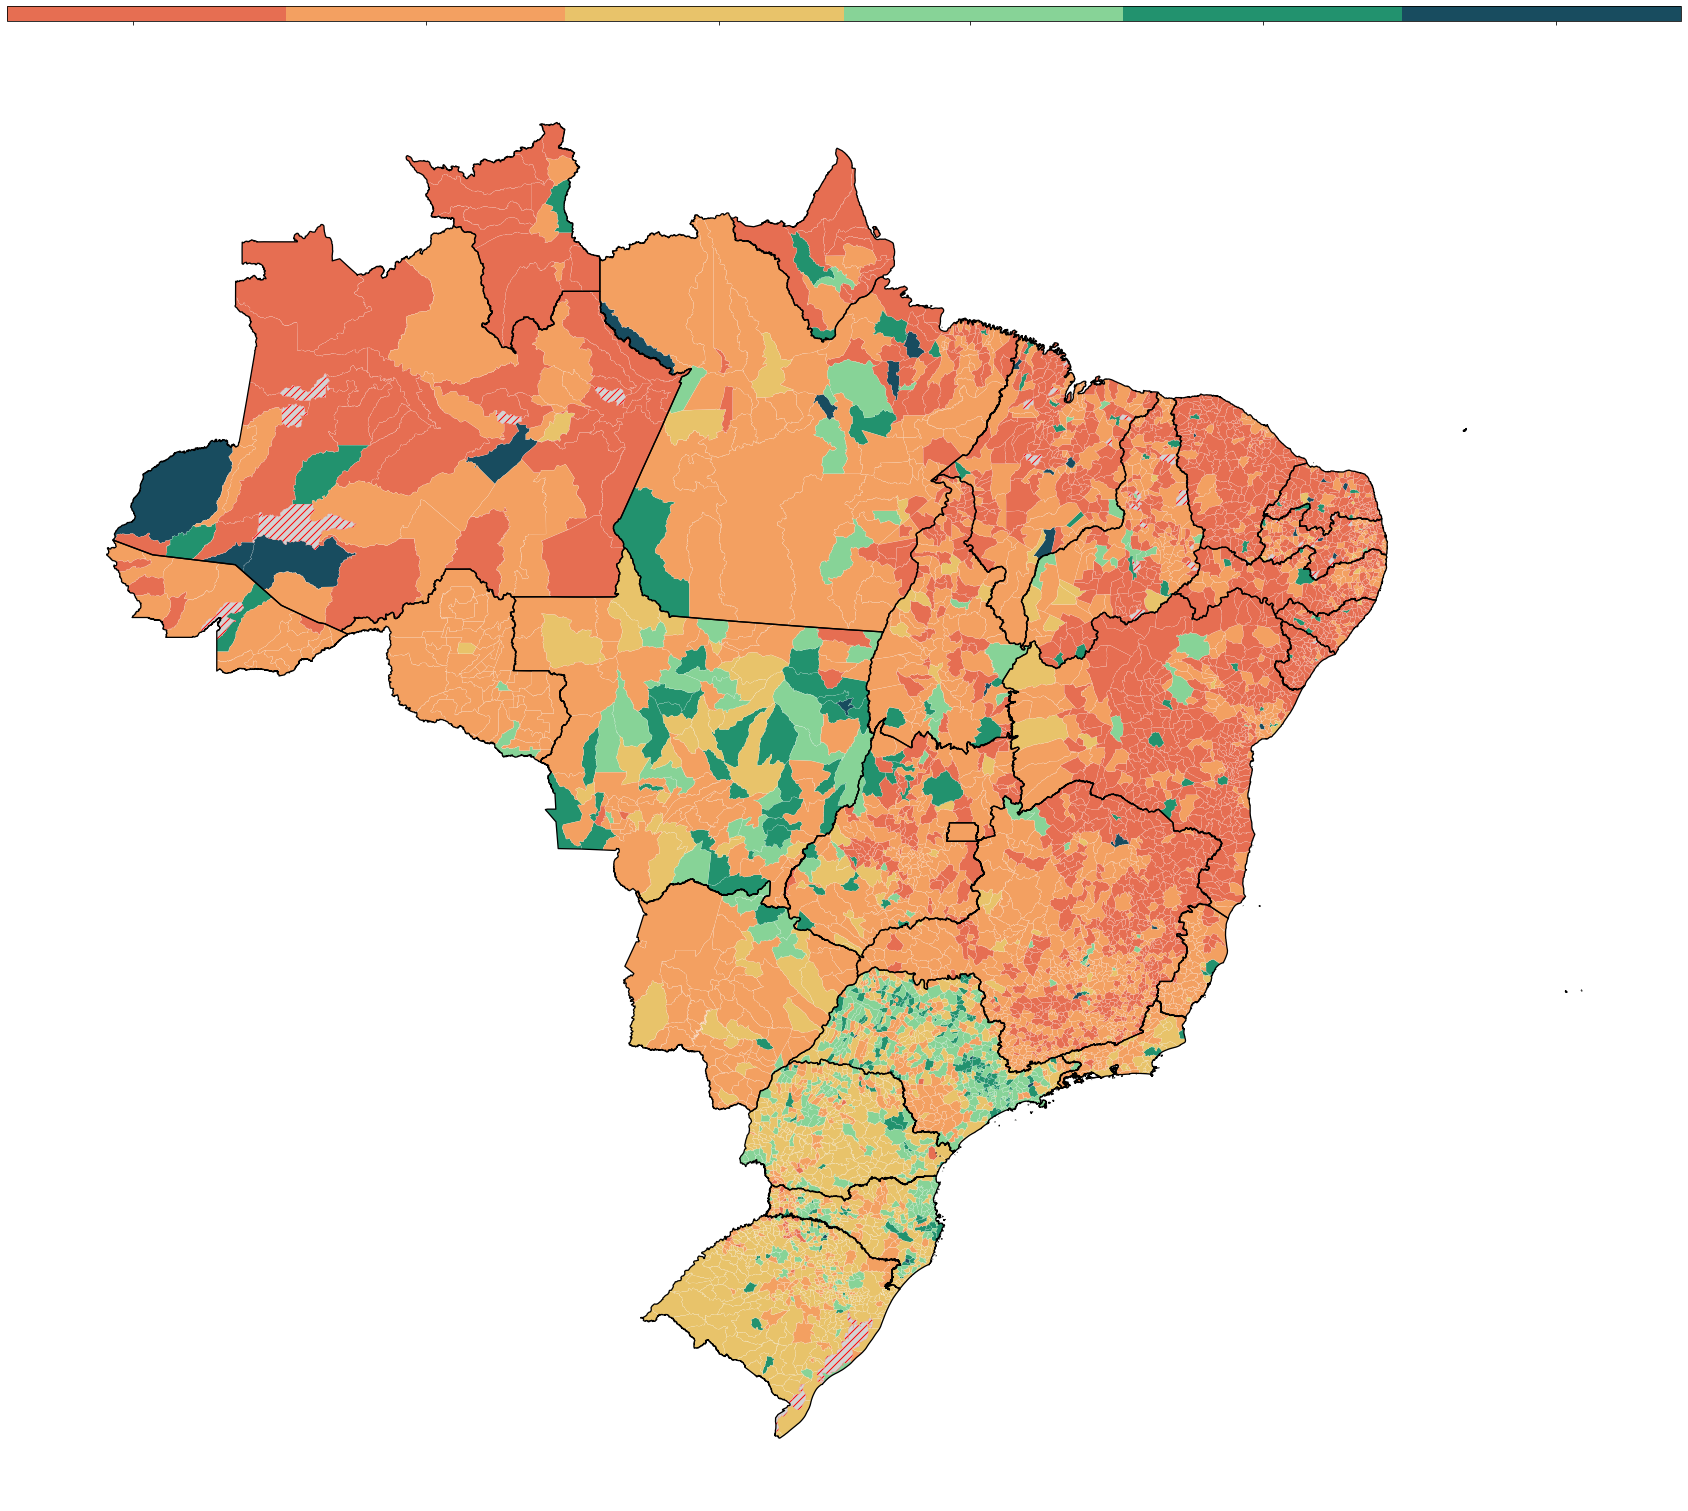

In [48]:
var='mediana_salario'

fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)

colors = [
         "#E66E52",
        "#F3A061",
        "#E8C36A",
        "#87D397",
        "#22926E",
        "#184C5F",
]



cmap = ListedColormap(colors)
colorscale = cmap

divider = make_axes_locatable(ax)
ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
vmax = dd[var].values.max()
vmin = dd[var].values.min()
norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
fig.add_axes(ax_cb)
labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
cbar = fig.colorbar(mappable, cax=ax_cb, ticks=labels,orientation='horizontal')
cbar.ax.set_xticklabels([])
cbar.ax.tick_params(labelsize=28) 

missing_kwds = {
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "NÃO CONSTA",
    }

dd.plot(column=var,
            ax=ax,
    #         legend=True,
#             legend_kwds = legend_kwds,
            cmap=cmap,
            missing_kwds=missing_kwds,
            scheme='user_defined', 
            classification_kwds={'bins':[1000,1200,1300,1400,1800,7200]},
            edgecolor='#FFFFFF',
            linewidth = 0.1
       )

states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)

ax.axis('off')

### Mediana salarial Infographic

In [22]:
def get_mapa_salario(ax,var):
    dd = pd.merge(caged_salario_2019,mun, left_on='id_municipio', right_on='code_muni', how='outer')
    dd = gpd.GeoDataFrame(dd).sort_values(by=var, ascending=False)

    colors = [
         "#E66E52",
        "#F3A061",
        "#E8C36A",
        "#87D397",
        "#22926E",
        "#184C5F",
    ]

    legenda = [
        'entre 0 e 1.000',
        ' 1.000 e 1.200',
        ' 1.200 e 1.300',
        ' 1.300 e 1.400',
        ' 1.400 e 1.800',
        'mais de 1.800'
    ]

    if var=='media_salario':
        t = 'Média'
    else:
        t = 'Mediana'
    ax.set_title(f'{t} Salarial no Brasil em 2019', fontsize=46,pad=100,fontweight='bold')

    missing_kwds = {
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "NÃO CONSTA",
        }

    cmap = ListedColormap(colors)
    colorscale = cmap

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_vertical(size="1%", pad=0.5, axes_class=plt.Axes)
    vmax = dd[var].values.max()
    vmin = dd[var].values.min()
    norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    mappable = plt.cm.ScalarMappable(cmap=colorscale, norm=norm)
    fig.add_axes(ax_cb)
    labels = [-0.085,-0.050, -0.015,0.015,0.05,0.085]
    cbar = fig.colorbar(mappable, cax=ax_cb, ticks=labels,orientation='horizontal')
    cbar.ax.set_xticklabels(legenda)
    cbar.ax.tick_params(labelsize=28) 


    dd.plot(column=var,
            ax=ax,
    #         legend=True,
#             legend_kwds = legend_kwds,
            cmap=cmap,
            missing_kwds=missing_kwds,
            scheme='user_defined', 
            classification_kwds={'bins':[1000,1200,1300,1400,1800,7200]},
            edgecolor='#FFFFFF',
            linewidth = 0.1
       )

    states.geometry.boundary.plot(color=None,edgecolor='#000000',linewidth = 1.3, ax=ax)

    ax.axis('off')
    ax.text(-38.7,-38.7,'Fonte: CAGED, basedosdados',fontsize=28)
#     plt.savefig(f'{var}.png', dpi=300, transparent=True, bbox_inches = 'tight', pad_inches = 0)

FileNotFoundError: [Errno 2] No such file or directory: 'bd_logo.png'

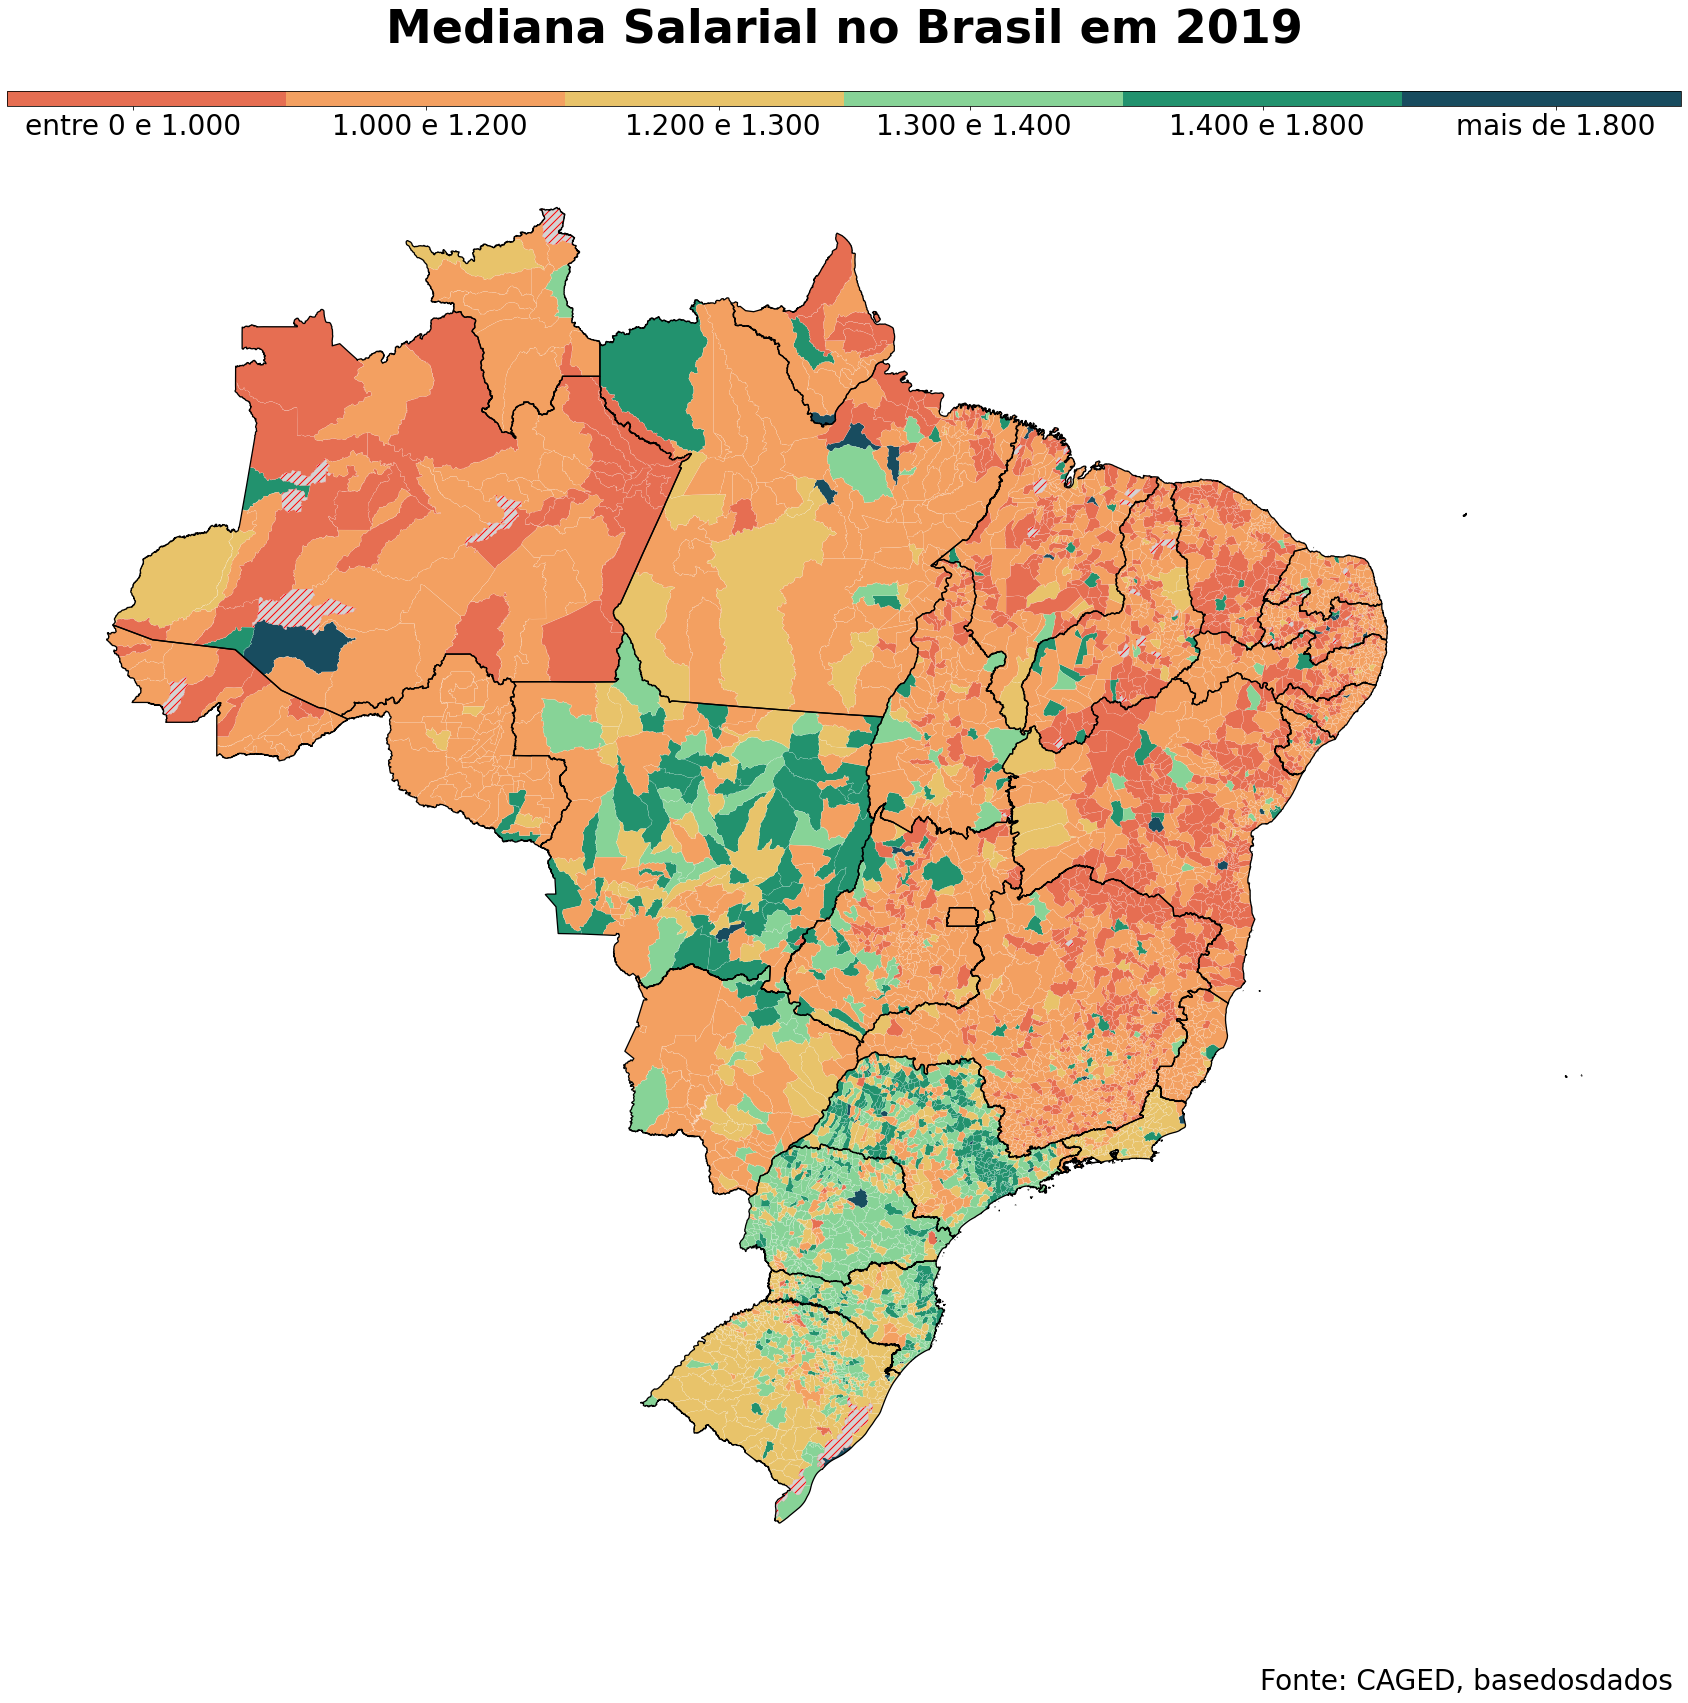

In [23]:
fig = plt.figure(figsize=(30,30))
ax = plt.subplot(1,1,1)
get_mapa_salario(ax, 'mediana_salario')